Logistic Regression Implementation


Test Accuracy = 0.95977
F1 Score = 0.959597
Precision = 0.96003
Recall = 0.95977


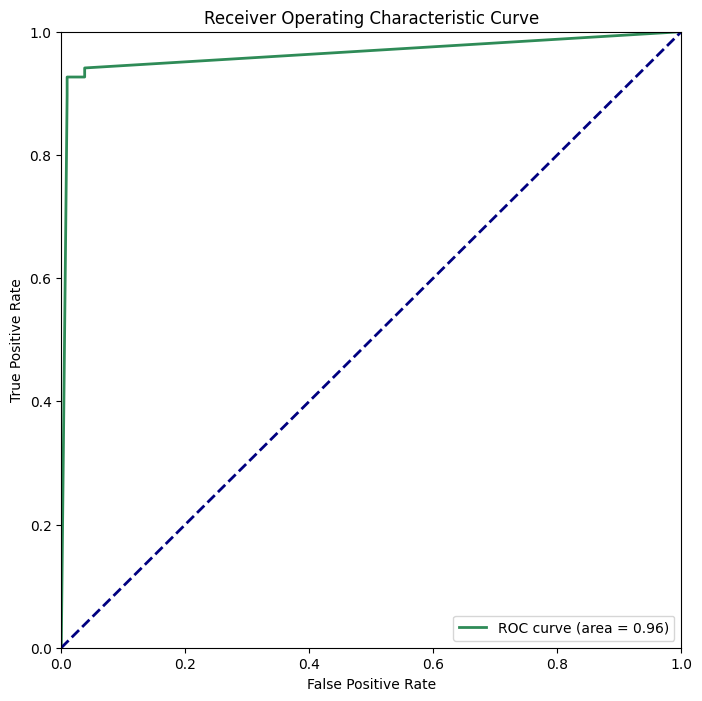

In [11]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import auc

print("Logistic Regression Implementation\n\n")

# Initialize Spark session
spark = SparkSession.builder.appName("CancerDiagnosisLogisticRegression").getOrCreate()

# Load dataset
data = spark.read.csv('./project3_data.csv', header=True, inferSchema=True)

# Data preprocessing
labelIndexer = StringIndexer(inputCol="diagnosis", outputCol="indexedDiagnosis").fit(data)  # Ensure consistent column naming
featureCols = data.columns
featureCols.remove('diagnosis')
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
(trainData, testData) = data.randomSplit([0.7, 0.3])

# Define and train the Logistic Regression model
lr = LogisticRegression(labelCol="indexedDiagnosis", featuresCol="features")
pipeline = Pipeline(stages=[labelIndexer, assembler, lr])
lrModel = pipeline.fit(trainData)

# Make predictions
predictions = lrModel.transform(testData)

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="indexedDiagnosis", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % accuracy)

# Evaluate additional metrics
f1_evaluator = MulticlassClassificationEvaluator(labelCol="indexedDiagnosis", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
print("F1 Score = %g" % f1_score)

precision_evaluator = MulticlassClassificationEvaluator(labelCol="indexedDiagnosis", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print("Precision = %g" % precision)

recall_evaluator = MulticlassClassificationEvaluator(labelCol="indexedDiagnosis", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
print("Recall = %g" % recall)

from sklearn.metrics import auc

def plot_roc_curve(predictions):
    # Convert Spark DataFrame to Pandas DataFrame
    predictions_pd = predictions.select("indexedDiagnosis", "probability").toPandas()

    y_true = predictions_pd["indexedDiagnosis"]
    y_scores = predictions_pd["probability"].apply(lambda x: x[1])

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='seagreen', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

# Check if binary classification
if data.select("diagnosis").distinct().count() == 2:
    # Make predictions
    predictions = lrModel.transform(testData)
    
    # Plot ROC Curve
    plot_roc_curve(predictions)
else:
    print("ROC curve not plotted as the classification problem is not binary.")

